In [1]:
# !pip install wandb -qU
# import wandb
# wandb.login()

In [2]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from tqdm import tqdm
from torchsummary import summary
from google.colab import drive
import zipfile
from torchvision.datasets.utils import download_url
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Import Data

In [3]:
if not os.path.exists('./download'):
  # Add your donwload path here
  dataset_url = 'https://drive.google.com/file/d/14swfL7Hz3FbX_DweHYkA8XWmucc8lf0M/view?usp=sharing'
  download_url(dataset_url,'./download', filename='generated_images_10Kids_cropped.zip')

  with zipfile.ZipFile('./download/generated_images_10Kids_cropped.zip', 'r') as tar:
      tar.extractall(path='.')

  image_folder = './generated_images_10Kids_cropped'

Downloading...
From (original): https://drive.google.com/uc?id=14swfL7Hz3FbX_DweHYkA8XWmucc8lf0M
From (redirected): https://drive.usercontent.google.com/download?id=14swfL7Hz3FbX_DweHYkA8XWmucc8lf0M&confirm=t&uuid=f7f27cde-fc1c-4a93-a24f-6c7040366b60
To: /content/download/generated_images_10Kids_cropped.zip
100%|██████████| 4.02G/4.02G [01:03<00:00, 63.2MB/s]


# DataLoader

In [4]:
import random

class FaceDataset(Dataset):
    def __init__(self, image_folder, people_dirs, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.people_dirs = people_dirs
        self.image_pairs = []
        self.labels = []
        self._prepare_data()

    def _prepare_data(self):
        #for person_dir in people_dirs:
        for i in range(1, int(len(self.people_dirs))):
            person_dir = self.people_dirs[i]
            person_path = os.path.join(self.image_folder, person_dir)
            images = os.listdir(person_path)
            for i in range(len(images)):
                for j in range(i + 1, len(images)):
                    self.image_pairs.append((os.path.join(person_path, images[i]), os.path.join(person_path, images[j])))
                    self.labels.append(1)

                    # Add negative samples
                    neg_person = person_dir
                    while neg_person == person_dir:
                        neg_person = self.people_dirs[torch.randint(len(self.people_dirs), (1,)).item()]


                    neg_images = os.listdir(os.path.join(self.image_folder, neg_person))
                    #if(neg_images):
                    self.image_pairs.append((os.path.join(person_path, images[i]), os.path.join(self.image_folder, neg_person, neg_images[0])))
                    self.labels.append(0)

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img1_path, img2_path = self.image_pairs[idx]
        label = self.labels[idx]
        img1 = Image.open(img1_path).convert('L')
        img2 = Image.open(img2_path).convert('L')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

# Split dataset into training, validation, and test sets
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    total_len = len(dataset)
    indices = list(range(total_len))
    random.shuffle(indices)

    train_end = int(train_ratio * total_len)
    val_end = train_end + int(val_ratio * total_len)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    return train_indices, val_indices, test_indices

# Load datasets


In [5]:
# Hyperparameters and setup
batch_size = 128
learning_rate = 0.01
#epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Batch size: {batch_size}')
print(f'LR: {learning_rate}')
#print(f'Epochs: {epochs}')
print(f'Device: {device}')


# Data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor()
])


# Split before
people_dirs = os.listdir(image_folder)

# Calculate the number of people to use (40%)
# num_people = len(people_dirs)
# num_to_use = int(num_people * 0.4)
# selected_people = random.sample(people_dirs, num_to_use)


# train-val and test set
train_val_dirs, test_dirs = train_test_split(people_dirs, test_size=0.2, random_state=42)
# train and val set
train_dirs, val_dirs  = train_test_split(train_val_dirs, test_size=0.2, random_state=42)


train_dataset = FaceDataset(image_folder, train_dirs, transform=transform)
val_dataset = FaceDataset(image_folder, val_dirs, transform=transform)
test_dataset = FaceDataset(image_folder, test_dirs, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Batch size: 128
LR: 0.01
Device: cuda


In [9]:
# Test Split

#from sklearn.model_selection import train_test_split
# Split before
#people_dirs = os.listdir(image_folder)
#train_people, val_people = train_test_split(people_dirs, test_size=0.2, random_state=42)
#print(len(train_people), len(val_people))

8000 2000


# Model

In [6]:
# Siamese Network
class TinySiameseNetwork(nn.Module):
    def __init__(self):
        super(TinySiameseNetwork, self).__init__()
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=1), # double to (1,4...)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(2, 4, kernel_size=3, stride=1, padding=1), # double to (4,8...)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1), # double to (4,8...)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1), # double to (4,8...)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(4, 2, kernel_size=3, stride=1, padding=1), # double to (4,8...)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(2*28*28, 8), # double to (8*28*28, 16)
            nn.ReLU(),
            nn.Linear(8, 1), # double to (16,1)
            nn.Sigmoid()
        )

    def forward_once(self, x):
        output = self.conv_net(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, img1, img2):
        output1 = self.forward_once(img1)
        output2 = self.forward_once(img2)
        return torch.abs(output1 - output2)


class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 14 * 14, 32)  # assuming the final conv layer's output is 14x14
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward_one(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # output size: (8, 56, 56)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # output size: (16, 28, 28)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)  # output size: (32, 14, 14)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        distance = torch.abs(output1 - output2)
        output = torch.sigmoid(self.fc3(distance))
        return output

# Train and Evaluate

In [7]:
# Evaluation function
def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for img1, img2, label in data_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            outputs = model(img1, img2).squeeze()
            loss = criterion(outputs, label)
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == label).sum().item()
            total += label.size(0)
    accuracy = correct / total
    return running_loss / len(data_loader), accuracy

# Training script with validation
def train(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for img1, img2, label in train_loader:
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)
                optimizer.zero_grad()
                outputs = model(img1, img2).squeeze()
                loss = criterion(outputs, label)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                pbar.set_postfix(loss=running_loss / (pbar.n + 1))
                pbar.update(1)

        val_loss, val_accuracy = evaluate(model, val_loader, criterion)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

        # Save the model
        torch.save(model.state_dict(), f'./network_epoch{epochs}.pth')

# Train model

In [7]:
epochs = 1

# Model, loss, and optimizer
model = SiameseNetwork().to(device)
summary(model, [(1, 112, 112), (1, 112, 112)])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train(model, train_loader, val_loader, criterion, optimizer, epochs=epochs)

# Evaluate on test set
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]              80
            Conv2d-2           [-1, 16, 56, 56]           1,168
            Conv2d-3           [-1, 32, 28, 28]           4,640
            Linear-4                   [-1, 32]         200,736
            Linear-5                   [-1, 16]             528
            Conv2d-6          [-1, 8, 112, 112]              80
            Conv2d-7           [-1, 16, 56, 56]           1,168
            Conv2d-8           [-1, 32, 28, 28]           4,640
            Linear-9                   [-1, 32]         200,736
           Linear-10                   [-1, 16]             528
           Linear-11                    [-1, 1]              17
Total params: 414,321
Trainable params: 414,321
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 600.25
Forwar

Epoch 1/1: 100%|██████████| 7597/7597 [32:20<00:00,  3.92batch/s, loss=0.441]


Epoch 1/1, Train Loss: 0.44087963281092685, Val Loss: 0.3938142698654636, Val Accuracy: 0.8249073387694589


RuntimeError: Parent directory networks does not exist.

# Load Model

In [10]:
model = SiameseNetwork().to(device)  # Instantiate the model

# Load the saved state dictionary
model.load_state_dict(torch.load(f'./network_epoch1.pth'))

# Set the model to evaluation mode
model.eval()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]              80
            Conv2d-2           [-1, 16, 56, 56]           1,168
            Conv2d-3           [-1, 32, 28, 28]           4,640
            Linear-4                   [-1, 32]         200,736
            Linear-5                   [-1, 16]             528
            Conv2d-6          [-1, 8, 112, 112]              80
            Conv2d-7           [-1, 16, 56, 56]           1,168
            Conv2d-8           [-1, 32, 28, 28]           4,640
            Linear-9                   [-1, 32]         200,736
           Linear-10                   [-1, 16]             528
           Linear-11                    [-1, 1]              17
Total params: 414,321
Trainable params: 414,321
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 600.25
Forwar

SiameseNetwork(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

# Visualize Example Predictions and Ground Truth

In [90]:
def predict_and_visualize(model, data_loader, num_pairs=10):
    model.eval()
    predictions = []
    image_pairs = []
    ground_truth = []
    count = 0

    with torch.no_grad():
        for img1, img2, label in data_loader:
            if count >= num_pairs:
                break

            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            outputs = model(img1, img2).squeeze()
            predicted = (outputs > 0.5).float()

            predictions.extend(predicted.cpu().numpy())
            image_pairs.extend(zip(img1.cpu().numpy(), img2.cpu().numpy()))
            ground_truth.extend(label.tolist())

            count += label.size(0)

    # Visualization
    fig, axes = plt.subplots(nrows=num_pairs, ncols=2, figsize=(10, 20))
    fig.suptitle("Predictions on Test Pairs", fontsize=16)

    for i in range(num_pairs):
        pair = image_pairs[i]
        pred = predictions[i]
        truth = ground_truth[i]

        # Ensure images are 2D and normalized if necessary
        img1 = pair[0].squeeze()
        img2 = pair[1].squeeze()

        # Convert 1/0 to "Same"/"Different"
        pred_text = "Same" if pred == 1 else "Different"
        truth_text = "Same" if truth == 1 else "Different"

        # Create a combined title
        combined_title = f"Pred: {pred_text}\n Truth: {truth_text}"
        fig.text(0.5, 1 - (i + 1) / (num_pairs + 1), combined_title, ha='center', va='center', fontsize=12)

        axes[i, 0].imshow(img1, cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].text(0.5, -0.1, "image 1", size=12, ha="center", transform=axes[i, 0].transAxes)

        axes[i, 1].imshow(img2, cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].text(0.5, -0.1, "image 2", size=12, ha="center", transform=axes[i, 1].transAxes)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

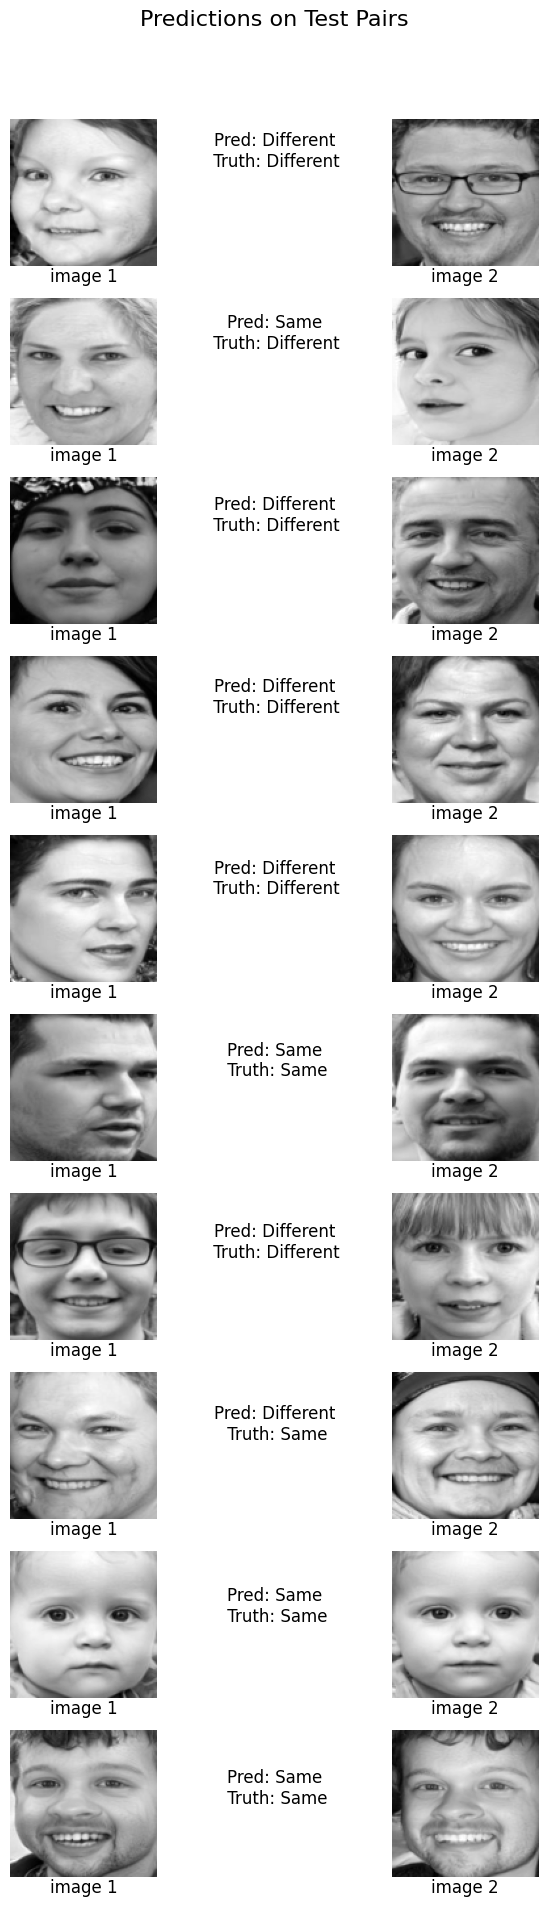

In [91]:
predict_and_visualize(model, test_loader)